In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.9.1


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14270178476427013278
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3654287360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1494954527766094146
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [70]:
batch_size = 100
seq_len = 150

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [71]:
folder = os.listdir('2-year sample')
os.listdir('2-year sample/' + folder[0])
df = pd.read_csv('2-year sample/' +  folder[0] + '/' + 'table_aapl.csv')
df = df.iloc[:,:7]
df.columns = ['Date','Time','Open','High','Low','Close','Volume']
for i in folder[1:]:
    try:
        df1 = pd.read_csv('2-year sample/' +  i + '/' + 'table_aapl.csv')
        df1 = df1.iloc[:,:7]
        df1.columns = ['Date','Time','Open','High','Low','Close','Volume']
        df = pd.concat([df,df1],axis = 0,ignore_index = True)
    except:
        continue

In [72]:
folder = os.listdir('aapl')
df = pd.read_csv('aapl/' +  folder[0])
df = df.iloc[:,:7]
df.columns = ['Date','Time','Open','High','Low','Close','Volume']
for i in folder[1:]:
    try:
        df1 = pd.read_csv('aapl/' +  i )
        df1 = df1.iloc[:,:7]
        df1.columns = ['Date','Time','Open','High','Low','Close','Volume']
        df = pd.concat([df,df1],axis = 0,ignore_index = True)
    except:
        continue

In [73]:
#a = pd.to_datetime(df['Date','Time'],format = "%Y%m%d%H%M" )
a = df["Date"].astype(str) + df["Time"].astype(str) 
df = df.drop('Time',axis = 1)
df["Date"] = a
df["Date"] = pd.to_datetime(df['Date'],format = "%Y%m%d%H%M" )

In [74]:
df.rename(columns = {'Date':'DateTime'},inplace = True)
df.set_index(df['DateTime'],inplace = True)
df = df.drop('DateTime',axis = 1)

In [75]:
df = df.resample('15min').mean()

In [76]:
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('DateTime', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 
df.describe()
# Drop all rows with NaN values

,Open,High,Low,Close,Volume
count,207970.000000,207970.000000,207970.000000,207970.000000,2.079700e+05
mean,20.481950,20.490792,20.472336,20.481919,8.902688e+05
std,26.650336,26.664841,26.633433,26.650249,9.942535e+05
min,0.108014,0.108272,0.107794,0.108074,4.648123e+02
25%,2.078571,2.079977,2.077116,2.078495,2.415852e+05
50%,10.921016,10.924210,10.918670,10.921542,5.917001e+05
75%,27.452576,27.459765,27.446851,27.452799,1.201447e+06
max,144.869807,144.896800,144.827933,144.872467,2.813693e+07


,Open,High,Low,Close,Volume
count,207970.000000,207970.000000,207970.000000,207970.000000,2.079700e+05
mean,20.481950,20.490792,20.472336,20.481919,8.902688e+05
std,26.650336,26.664841,26.633433,26.650249,9.942535e+05
min,0.108014,0.108272,0.107794,0.108074,4.648123e+02
25%,2.078571,2.079977,2.077116,2.078495,2.415852e+05
50%,10.921016,10.924210,10.918670,10.921542,5.917001e+05
75%,27.452576,27.459765,27.446851,27.452799,1.201447e+06
max,144.869807,144.896800,144.827933,144.872467,2.813693e+07


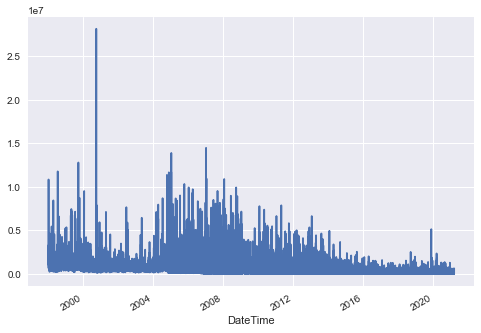

In [77]:
df.dropna(how='any', axis=0, inplace=True) 
df.Volume.plot()
df.describe()

In [78]:
'''Calculate percentage change'''


df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Close','High']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Close','High']].max(axis=0))

# Min-max normalize price columns (0-1 range)

df['Close'] = (df['Close'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''



###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]
'''
# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)
'''
# Convert pandas columns into arrays
train_data = df_train[['Close','High']].values
val_data = df_val[['Close','High']].values
test_data = df_test[['Close','High']].values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

del(df)
df_train.head()

Training data shape: (166376, 2)
Validation data shape: (20797, 2)
Test data shape: (20797, 2)


,Open,High,Low,Close,Volume
DateTime,,,,,
1998-01-02 11:15:00,0.108014,0.000005,0.107794,0.000000,2.362410e+06
1998-01-02 11:30:00,0.108874,0.000029,0.108632,0.000023,2.466520e+06
1998-01-02 11:45:00,0.109636,0.000050,0.109394,0.000044,2.513694e+06
1998-01-02 12:00:00,0.110496,0.000073,0.110247,0.000068,2.462546e+06
1998-01-02 12:15:00,0.111529,0.000102,0.111274,0.000096,2.407881e+06


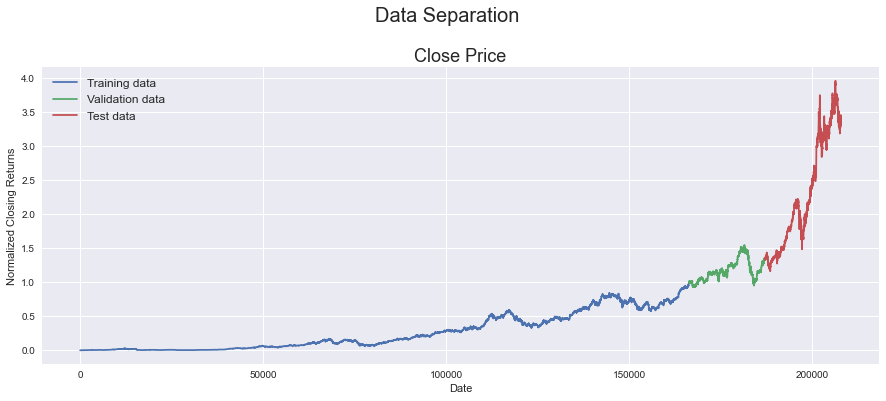

In [79]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################


In [82]:

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:,1][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:,1][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:,1][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (166226, 150, 2) (166226,)
Validation set shape (20647, 150, 2) (20647,)
Testing set shape (20647, 150, 2) (20647,)


In [83]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x,x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [84]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [85]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = tf.keras.callbacks.ModelCheckpoint('Transformers', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[callbacks,early_stop]
)

model.evaluate(X_test, y_test, verbose=1)

Epoch 1/200
2078/2078 [==============================] - 181s 86ms/step - loss: 0.0479 - val_loss: 0.1332

Epoch 00001: val_loss improved from inf to 0.13321, saving model to Transformers


INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 2/200
2078/2078 [==============================] - 181s 87ms/step - loss: 0.0080 - val_loss: 0.0111

Epoch 00002: val_loss improved from 0.13321 to 0.01107, saving model to Transformers


INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 3/200
2078/2078 [==============================] - 180s 86ms/step - loss: 0.0046 - val_loss: 0.0243

Epoch 00003: val_loss did not improve from 0.01107
Epoch 4/200
2078/2078 [==============================] - 180s 87ms/step - loss: 0.0029 - val_loss: 0.0344

Epoch 00004: val_loss did not improve from 0.01107
Epoch 5/200
2078/2078 [==============================] - 180s 87ms/step - loss: 0.0020 - val_loss: 0.0091

Epoch 00005: val_loss improved from 0.01107 to 0.00910, saving model to Transformers


INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 6/200
2078/2078 [==============================] - 181s 87ms/step - loss: 0.0014 - val_loss: 0.0171

Epoch 00006: val_loss did not improve from 0.00910
Epoch 7/200
2078/2078 [==============================] - 181s 87ms/step - loss: 0.0010 - val_loss: 0.0019

Epoch 00007: val_loss improved from 0.00910 to 0.00186, saving model to Transformers


INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 8/200
2078/2078 [==============================] - 180s 87ms/step - loss: 9.2675e-04 - val_loss: 0.0021

Epoch 00008: val_loss did not improve from 0.00186
Epoch 9/200
2078/2078 [==============================] - 180s 87ms/step - loss: 8.2726e-04 - val_loss: 9.5640e-04

Epoch 00009: val_loss improved from 0.00186 to 0.00096, saving model to Transformers


INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 10/200
2078/2078 [==============================] - 181s 87ms/step - loss: 7.6216e-04 - val_loss: 5.4437e-04

Epoch 00010: val_loss improved from 0.00096 to 0.00054, saving model to Transformers


INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 11/200
2078/2078 [==============================] - 181s 87ms/step - loss: 7.2366e-04 - val_loss: 0.0022

Epoch 00011: val_loss did not improve from 0.00054
Epoch 12/200
2078/2078 [==============================] - 181s 87ms/step - loss: 7.1735e-04 - val_loss: 2.3586e-04

Epoch 00012: val_loss improved from 0.00054 to 0.00024, saving model to Transformers


INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 13/200
2078/2078 [==============================] - 181s 87ms/step - loss: 6.6547e-04 - val_loss: 9.0980e-05

Epoch 00013: val_loss improved from 0.00024 to 0.00009, saving model to Transformers


INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 14/200
2078/2078 [==============================] - 181s 87ms/step - loss: 6.5555e-04 - val_loss: 8.0082e-04

Epoch 00014: val_loss did not improve from 0.00009
Epoch 15/200
2078/2078 [==============================] - 181s 87ms/step - loss: 6.4229e-04 - val_loss: 9.1903e-04

Epoch 00015: val_loss did not improve from 0.00009
Epoch 16/200
2078/2078 [==============================] - 181s 87ms/step - loss: 6.1346e-04 - val_loss: 1.9094e-04

Epoch 00016: val_loss did not improve from 0.00009
Epoch 17/200
2078/2078 [==============================] - 181s 87ms/step - loss: 6.1446e-04 - val_loss: 1.8143e-04

Epoch 00017: val_loss did not improve from 0.00009
Epoch 18/200
2078/2078 [==============================] - 181s 87ms/step - loss: 6.1063e-04 - val_loss: 9.8575e-05

Epoch 00018: val_loss did not improve from 0.00009
Epoch 19/200
2078/2078 [==============================] - 181s 87ms/step - loss: 6.2252e-04 - val_loss: 0.0011

Epoch 00019: val_loss did not improve from 0.00009
Ep

INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 26/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.8296e-04 - val_loss: 6.0137e-04

Epoch 00026: val_loss did not improve from 0.00008
Epoch 27/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.9694e-04 - val_loss: 4.7657e-04

Epoch 00027: val_loss did not improve from 0.00008
Epoch 28/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.9631e-04 - val_loss: 4.0733e-04

Epoch 00028: val_loss did not improve from 0.00008
Epoch 29/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.9583e-04 - val_loss: 9.8758e-04

Epoch 00029: val_loss did not improve from 0.00008
Epoch 30/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.8798e-04 - val_loss: 4.7472e-04

Epoch 00030: val_loss did not improve from 0.00008
Epoch 31/200
2078/2078 [==============================] - 182s 87ms/step - loss: 5.8032e-04 - val_loss: 3.3025e-04

Epoch 00031: val_loss did not improve from 0.0000

INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 43/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.7380e-04 - val_loss: 7.5822e-04

Epoch 00043: val_loss did not improve from 0.00005
Epoch 44/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.7824e-04 - val_loss: 4.1225e-04

Epoch 00044: val_loss did not improve from 0.00005
Epoch 45/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.7204e-04 - val_loss: 5.6590e-04

Epoch 00045: val_loss did not improve from 0.00005
Epoch 46/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.7262e-04 - val_loss: 4.4432e-04

Epoch 00046: val_loss did not improve from 0.00005
Epoch 47/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.7278e-04 - val_loss: 5.6616e-04

Epoch 00047: val_loss did not improve from 0.00005
Epoch 48/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.7631e-04 - val_loss: 3.7036e-04

Epoch 00048: val_loss did not improve from 0.0000

INFO:tensorflow:Assets written to: Transformers\assets


INFO:tensorflow:Assets written to: Transformers\assets


Epoch 66/200
2078/2078 [==============================] - 182s 87ms/step - loss: 5.7393e-04 - val_loss: 7.3996e-05

Epoch 00066: val_loss did not improve from 0.00005
Epoch 67/200
2078/2078 [==============================] - 182s 87ms/step - loss: 5.6283e-04 - val_loss: 2.4801e-04

Epoch 00067: val_loss did not improve from 0.00005
Epoch 68/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.6941e-04 - val_loss: 5.0317e-04

Epoch 00068: val_loss did not improve from 0.00005
Epoch 69/200
2078/2078 [==============================] - 181s 87ms/step - loss: 5.6628e-04 - val_loss: 0.0010

Epoch 00069: val_loss did not improve from 0.00005
Epoch 70/200
2078/2078 [==============================] - 182s 87ms/step - loss: 5.6464e-04 - val_loss: 2.4965e-04

Epoch 00070: val_loss did not improve from 0.00005
Epoch 71/200
2078/2078 [==============================] - 174s 84ms/step - loss: 5.6546e-04 - val_loss: 4.5994e-04

Epoch 00071: val_loss did not improve from 0.00005
Ep

0.005448999349027872

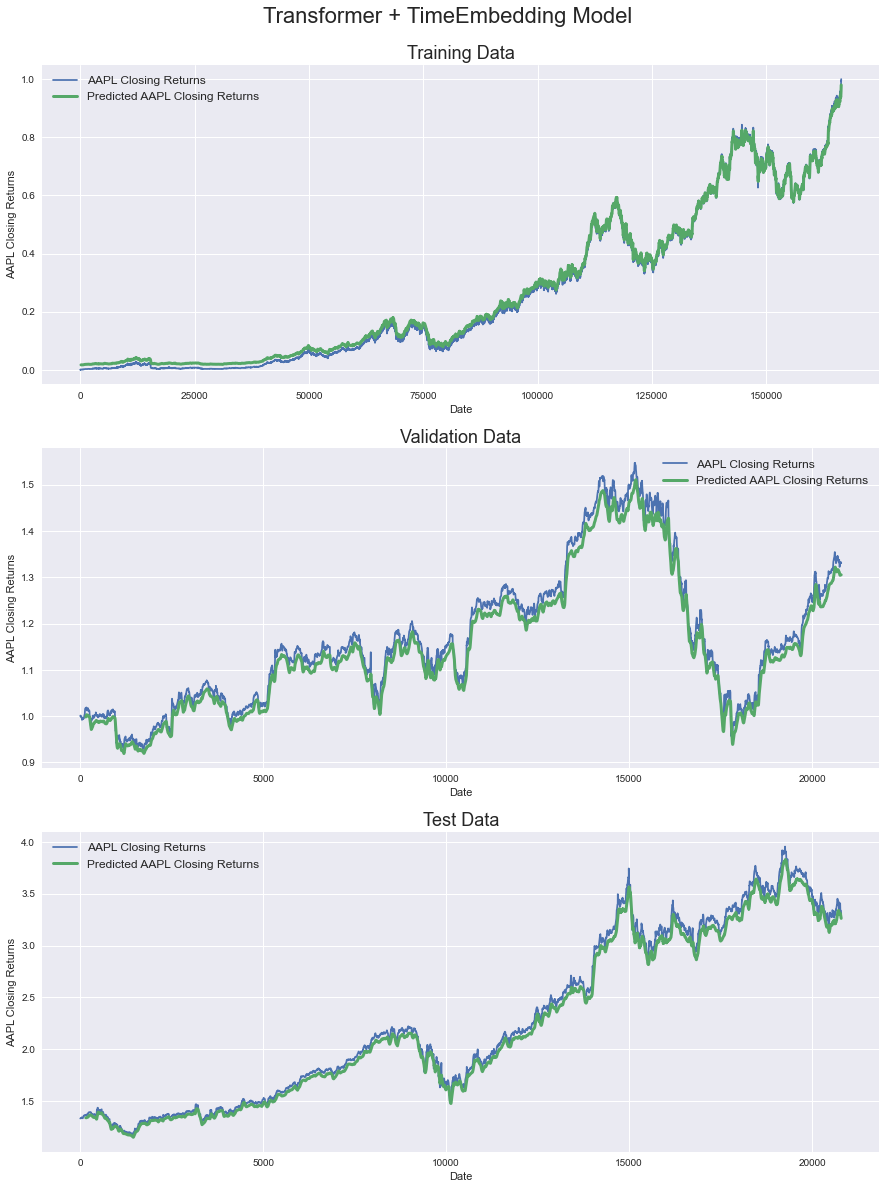

In [87]:
model = tf.keras.models.load_model("Transformers")
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
'''
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

'''

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 0], label='AAPL Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted AAPL Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('AAPL Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 0], label='AAPL Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted AAPL Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('AAPL Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 0], label='AAPL Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted AAPL Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('AAPL Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [26]:
val_pred,y_val

(array([[0.6807565],
        [0.6807565],
        [0.6807565],
        ...,
        [0.6807565],
        [0.6807565],
        [0.6807565]], dtype=float32),
 array([0.6809115 , 0.68073443, 0.68073563, ..., 0.6804784 , 0.68105861,
        0.68104562]))

In [ ]:
model = tf.keras.models.load_model('Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='AAPL Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted AAPL Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('AAPL Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='AAPL Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted AAPL Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('AAPL Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='AAPL Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted AAPL Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('AAPL Closing Returns')
ax31.legend(loc="best", fontsize=12)